# NN

问题：估计出度为均值（21.75）附近的节点在渗流率为0.012的场景下的属于GIN的概率（也就是作为信息源点能把信息传开的概率） 方法：神经网络的方法

In [1]:
import os
os.chdir('/home/percy/Documents/Projects/ComplexNetwork')

import numpy as np
import matplotlib.pyplot as plt
import torch
import random


import cn.data.load_data as load_data
import cn.data.convert_data as convert_data
import cn.ml.util as mlutil
import cn.ml.cm as mlcm

In [5]:
import sys
import json

In [3]:
from scipy import sparse

In [4]:
with open('data/snap_twitter/nodes_degree_approx_20.json', 'r') as fr:
    nodes_degree_approx_20 = json.load(fr)
    
node2vec_emb = load_data.load_node2vec_emb('data/snap_twitter/snap_twitter.node2vec.emb')

with open('data/snap_twitter/p_gin/p_gin_beta0.0120.json', 'r') as fr:
    p_gins = json.load(fr)

## Train Model

每次从总体中取出10%的点，训练出一个神经网络模型；重复十次

### Sample

samples = convert_data.sampling_and_converting(...)

### Hyperparameters

-   model = mlcm.ThreeLayersSequatialTanh(...)
-   loss_fn: MSELoss
-   optimizer: Adam
-   lr = 1e-4
-   n_epochs = 5000

In [17]:
def train_models():
    """每次采样10%的点，训练数据测试数据随机8：2，训练出10个模型，挑选测试误差最小的那个。
    重复该过程10次。
    """
    models = []
    for i in range(10):
        print(f'i = {i}:', end='\t')
        # 随机采样
        samples = convert_data.sampling_and_converting(nodes_degree_approx_20,
                                                       node2vec_emb, p_gins)
        loss_min = sys.float_info.max
        model_loss_min = None
        for j in range(10):
            print(j, end=' ')
            model = mlcm.ThreeLayersSequentialTanh(128, 1, 80, 40)
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
            # 随机分训练数据和验证数据
            train_validate_samples = mlutil.split_samples(samples)
            _, validate_losses = mlutil.training_loop(model, loss_fn, optimizer,
                                                      *train_validate_samples, 
                                                      n_epochs=1000)
            # 更新最优模型
            if validate_losses[-1] < loss_min:
                model_loss_min = model
                loss_min = validate_losses[-1]
        print('\t', loss_min)
        models.append(model_loss_min)
    return models

In [18]:
models = train_models()

i = 0:	0 1 2 3 4 5 6 7 8 9 	 0.00027812528423964977
i = 1:	0 1 2 3 4 5 6 7 8 9 	 0.00026384572265669703
i = 2:	0 1 2 3 4 5 6 7 8 9 	 0.00021232967264950275
i = 3:	0 1 2 3 4 5 6 7 8 9 	 0.00020710911485366523
i = 4:	0 1 2 3 4 5 6 7 8 9 	 0.0002963529259432107
i = 5:	0 1 2 3 4 5 6 7 8 9 	 0.00025800717412494123
i = 6:	0 1 2 3 4 5 6 7 8 9 	 0.0002871386241167784
i = 7:	0 1 2 3 4 5 6 7 8 9 	 9.684824181022123e-05
i = 8:	0 1 2 3 4 5 6 7 8 9 	 0.00018854787049349397
i = 9:	0 1 2 3 4 5 6 7 8 9 	 0.00023024668917059898


In [22]:
folder = 'data/snap_twitter/cn20/cn20_beta0.0120/nn_models/'
for i, m in enumerate(models):
    torch.save(m.state_dict(), folder + f'model{i}.pt')

## Critical User Identification

In [26]:
with open('data/snap_twitter/cn 20.json') as fr:
    cn20 = json.load(fr)

In [35]:
def sort_cns(cns: list, node2vec_emb: dict, model: torch.nn.Module) -> list:
    nn_cns = torch.Tensor([node2vec_emb[cn] for cn in cns])
    p_gins = model(nn_cns)
    p_gins_sorted, indices = torch.sort(p_gins, 0, True)
    return [cns[i] for i in indices]

In [40]:
for i in range(10):
    model = mlcm.ThreeLayersSequentialTanh(128, 1, 80, 40)
    path = folder + f'model{i}.pt'
    model.load_state_dict(torch.load(path))
    model.eval()
    cn20_sorted = []
    for cns in cn20:
        cns_sorted = sort_cns(cns, node2vec_emb, model)
        cn20_sorted.append(cns_sorted)
        
    dst = folder + f'cn20_sorted{i}.json'
    with open(dst, 'w') as fw:
        json.dump(cn20_sorted, fw)    

## Calculate Spread Power

In [38]:
mat_path = 'data/snap_twitter/gin_mat/0.0120.npz'
gin_mat = sparse.load_npz(mat_path).toarray()

In [6]:
gout_size = 2121.119174379556

In [42]:
def cal_sp(seeds, gin_mat, gout_size: float):
    """
    gin_mat: 2d-array
    return: list
    """
    sub_mat = gin_mat[np.array(seeds)]
    virus_mat = np.cumsum(sub_mat, axis=0) > 0
    virus = virus_mat.sum(axis=1)
    sp = virus / gin_mat.shape[1] * gout_size
    return list(sp)

In [43]:
for i in range(10):
    src = folder + f'cn20_sorted{i}.json'
    with open(src) as fr:
        cn20_sorted = json.load(fr)
    cn20_sp = []
    for cns in cn20_sorted:
        sps = cal_sp(cns, gin_mat, gout_size)
        cn20_sp.append(sps)
    dst = folder + f'cn20_sp{i}.json'
    with open(dst, 'w') as fw:
        json.dump(cn20_sp, fw)

In [54]:
sp = np.zeros(100)
for i in range(10):
    src = folder + f'cn20_sp{i}.json'
    with open(src) as fr:
        cn20_sp = json.load(fr)
    for sps in cn20_sp:
        sp += np.array(sps)
sp = sp / (10 * 100)
dst = folder + 'cn20_sp_total.json'
with open(dst, 'w') as fw:
    json.dump(list(sp), fw)

In [51]:
sp = len(sp)

In [53]:
dst = folder + 'cn20_sp_total.json'
with open(dst, 'w') as fw:
    json.dump(sp, fw)

In [10]:
src = folder + 'cn20_sp_total.json'
with open(src) as fr:
    y = json.load(fr)
y = list(np.array(y) / gout_size)

## Plot

In [12]:
with open('data/snap_twitter/img/graph/20 0.0120 [P_GIN, NPBGA].json') as fr:
    data1 = json.load(fr)
# data2 = list(sp / gout_size)

In [13]:
with open('data/snap_twitter/img/graph/20 0.0120 [NPBGA, PBGA, MD, MKS, MC, CI].json') as fr:
    data3 = json.load(fr)
yk = []
for k in data3:
    yk.append(data3[k]['MKS'])

In [72]:
y = data2

In [14]:
yp, yn = [], []
for k in data1:
    yp.append(data1[k]['P_GIN'])
    yn.append(data1[k]['NPBGA'])

In [69]:
x = list(range(100))

In [83]:
ax.cla()
ax.plot(x, y, 'k', label='NN_PGIN')
ax.plot(x, yk, '-.', c='gray', label='MKS')
ax.plot(x, yp, '--', c='gray', label='PGIN')

In [87]:
ax.grid(alpha=0.2)

In [94]:
ax.legend(fontsize=12)

In [95]:
fig.tight_layout()

In [96]:
fig.savefig('data/snap_twitter/img/NN_PGIN-PGIN-MKS.png')

In [92]:
ax.set_xlabel('# seeds', fontsize=16)
ax.set_ylabel(r'$S(V)/S^\infty$', fontsize=16)

Text(51.166666666666664, 0.5, '$S(V)/S^\\infty$')

In [91]:
type(ax.get_xlabel())

str

<IPython.core.display.Javascript object>


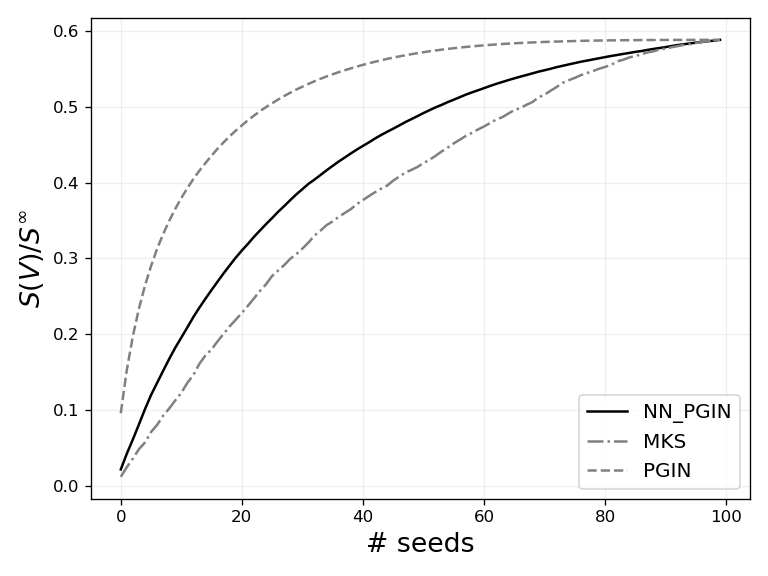

In [68]:
fig, ax = plt.subplots()

In [18]:
data = {'x': list(range(100)), 'PGIN': yp, 'NN_PGIN': y, 'MKS': yk}
with open('data/snap_twitter/img/NN_PGIN-PGIN-MKS.json', 'w') as fw:
    json.dump(data, fw)